## Project Initialisation

### Import librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import ast

from transformers import pipeline
from collections import defaultdict
from transformers import pipeline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels import tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


### Constants 

In [3]:
RAW_DATA_FOLDER_PATH = 'data/raw/'
PROCESSED_DATA_FOLDER_PATH = 'data/processed/'

### Preprocessing of the plot summaries dataset

In [4]:
# Load the plot summaries
column_names = ["wikipedia_movie_id", "plot"]
df_plot_summaries = pd.read_csv(RAW_DATA_FOLDER_PATH + 'plot_summaries.txt', sep="\t", names=column_names)

# Filtering of the movies which are not in our other filtered dataset
df_imdb_metadata_filtered = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + 'imdb_ratings.csv')
df_plot_summaries_filtered = df_plot_summaries[df_plot_summaries['wikipedia_movie_id'].isin(df_imdb_metadata_filtered['wikipedia_movie_id'])]
df_plot_summaries_filtered.reset_index(drop=True, inplace=True)

# For more readibility
df_plot_summaries = df_plot_summaries_filtered.copy()

# Add the movie title to the plot summaries
df_movies_metadata = pd.read_csv(PROCESSED_DATA_FOLDER_PATH+'movies_metadata.csv')
df_plot_summaries_filtered['movie_title'] = df_plot_summaries['wikipedia_movie_id'].map(df_movies_metadata.set_index('wikipedia_movie_id')['movie_name'].to_dict())

# Add the director and their gender for each plot summary
df_movies_directors = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + 'movies_director.csv')
df_plot_summaries['director'] = df_plot_summaries['wikipedia_movie_id'].map(df_movies_directors.set_index('wikipedia_movie_id')['Director'].to_dict())
df_plot_summaries['director_gender'] = df_plot_summaries['wikipedia_movie_id'].map(df_movies_directors.set_index('wikipedia_movie_id')['Gender'].to_dict())

## Sentiment analysis on the plot summaries

### Obtaining emotions for all plot summeries  

In [9]:
# Load the pipeline with a specific emotion model
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Function for analyzing the emotion of a text
def emotion_analysis(text):
    chunks = [text[i:i+512] for i in range(0, len(text), 512)]
    results = [emotion_pipeline(chunk) for chunk in chunks]

    # Initialize a dictionary to accumulate scores for each emotion
    emotion_scores = defaultdict(list)

    #Process each chunk and accumulate scores
    for chunk_result in results:
        for emotion in chunk_result:
            for i in range(len(emotion)):
                emotion_scores[emotion[i]['label']].append(emotion[i]['score'])
            #print(emotion_scores[emotion['label']])
            #emotion_scores[emotion['label']].append(emotion['score'])

    # Calculate the average score for each emotion
    average_scores = {emotion: sum(scores) / len(scores) for emotion, scores in emotion_scores.items()}

    return average_scores


# Function for processing all film summaries 
def emotion_score_big_dataset_csv(df, output_file, from_index, to_index, batch_size):
    for i in range(from_index, to_index, batch_size):
        batch = df.iloc[i:i + batch_size]

        batch['emotion_scores'] = batch['plot'].apply(emotion_analysis)
        batch['dominant_emotion'] = batch['emotion_scores'].apply(lambda x: max(x, key=x.get))

        batch.to_csv(output_file, mode='a', index=False, header=not os.path.exists(output_file))


In [ ]:
# Creation of the csv with all the emotions scores
output_file = PROCESSED_DATA_FOLDER_PATH + 'plot_emotions.csv'
emotion_score_big_dataset_csv(df_plot_summaries, output_file, 0, df_plot_summaries.shape[0], batch_size=100)

In [5]:
# Dataframe with the emotions scores
df_plot_emotions = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + 'plot_emotions.csv')

### Graphs

#### Distribution of emotions in plot summaries

In [6]:
# Funtion to plot the distribution of emotions, in proportion to the scores obtained in the plot summaries
def graph_emotions(df):
    emotion_totals = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'joy': 0,
    'neutral': 0,
    'sadness': 0,
    'surprise': 0
    }
    for emotion_score in df['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals[emotion] += score

    fig = px.pie(
        values=list(emotion_totals.values()),
        names=list(emotion_totals.keys()),
        title='Emotions in Plot Summaries',
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    fig.show()



In [7]:
graph_emotions(df_plot_emotions)

#### Ratio emotion by director gender

In [8]:
def ratio_emotion_by_director_gender(df_plot_emotions):
    df_plot_emotions_women = df_plot_emotions[df_plot_emotions['director_gender'] == 'F']
    df_plot_emotions_men = df_plot_emotions[df_plot_emotions['director_gender'] == 'M']

    emotion_totals_women = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    }
    emotion_totals_men = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    }

    for emotion_score in df_plot_emotions_women['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals_women[emotion] += score

    for emotion_score in df_plot_emotions_men['emotion_scores']:
        scores = ast.literal_eval(emotion_score)
        for emotion, score in scores.items():
            emotion_totals_men[emotion] += score


    # Calculating ratios
    total_women = sum(emotion_totals_women.values())
    total_men = sum(emotion_totals_men.values())

    ratios_women = {emotion: value / total_women * 100 for emotion, value in emotion_totals_women.items()}
    ratios_men = {emotion: value / total_men * 100 for emotion, value in emotion_totals_men.items()}

    return ratios_women, ratios_men

def graph_ratio_emotion_by_director_gender(ratios_women, ratios_men):
    # Transformation into a DataFrame for Plotly
    df = pd.DataFrame({
        'Emotion': list(ratios_women.keys()),
        'Women': list(ratios_women.values()),
        'Men': list(ratios_men.values())
    })

    fig = px.bar(
        df,
        x='Emotion',
        y=['Women', 'Men'],
        title='Ratio of Emotions by Gender',
        labels={'value': 'Ratio (%)', 'Emotion': 'Emotion'},
        barmode='group',
        color_discrete_map={
            "Women": "royalblue",
            "Men": "gold"
        }
    )

    # 
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        xaxis_title="Emotion",
        yaxis_title="Ratio (%)",
        legend_title="Director Gender",
        template="plotly_white"
    )

    fig.show()

In [9]:
# Graph of the ratio of emotions by director gender
ratios_women, ratios_men = ratio_emotion_by_director_gender(df_plot_emotions)
graph_ratio_emotion_by_director_gender(ratios_women, ratios_men)

#### Radar Ratio emotion by director gender

In [10]:
def graph_ratio_emotion_radar_by_director_gender(ratios_women, ratios_men):
    emotions = list(ratios_women.keys())
    values_women = list(ratios_women.values())
    values_men = list(ratios_men.values())
    
    # To close the radar, add the first dot at the end
    emotions += [emotions[0]]
    values_women += [values_women[0]]
    values_men += [values_men[0]]
    

    fig = go.Figure()
    # Female directors
    fig.add_trace(go.Scatterpolar(
        r=values_women,
        theta=emotions,
        fill='toself',
        name='Female Directors',
        line=dict(color='royalblue'),
        marker=dict(size=6)
    ))
    # Male directors
    fig.add_trace(go.Scatterpolar(
        r=values_men,
        theta=emotions,
        fill='toself',
        name='Male Directors',
        line=dict(color='gold'),
        marker=dict(size=6)
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True),
        ),
        title='Ratio of Emotion in Plot Summaries by Director Gender',
        legend_title="Director Gender",
        template="plotly_white"
    )

    fig.show()


In [11]:
# radar graph of the ratio of emotions by director
ratios_women, ratios_men = ratio_emotion_by_director_gender(df_plot_emotions)
graph_ratio_emotion_radar_by_director_gender(ratios_women, ratios_men)

## Combining plot summaries analysis with bechdel test

### Data loading

In [24]:
# load bechdel
df_bechdel = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + 'bechdel_ratings.csv')

# load characters metadata
df_char_metadata = pd.read_csv(PROCESSED_DATA_FOLDER_PATH + "characters_metadata.csv")

# transform movies
df_movies = df_movies_metadata[["wikipedia_movie_id", "movie_release_date", "movie_genres", "movie_countries"]]
# groupby to make a list that contains all genders for a given movie
genders_grouped = (
    df_char_metadata.groupby("wikipedia_movie_id")["actor_gender"]
    .apply(list)  # Collect genders into lists
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={"actor_gender": "actor_genders"})  # Rename the column
)
# merging
df_movies = df_movies.merge(genders_grouped, on="wikipedia_movie_id", how="left")
df_movies['movie_genres'] = df_movies['movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_movies['movie_countries'] = df_movies['movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# define male/female directors
movies_M = df_movies_directors[df_movies_directors["Gender"].apply(lambda x: x=="M")]
movies_F = df_movies_directors[df_movies_directors["Gender"].apply(lambda x: x=="F")]


### Data Augmentation

In [25]:
# adding genres, countries, genders
df_bechdel = pd.merge(
    df_bechdel,
    df_movies[['wikipedia_movie_id', "movie_genres", "movie_countries", "actor_genders"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)

# adding director gender
df_bechdel["director_gender"] = df_bechdel["wikipedia_movie_id"].apply(
    lambda x: int(0) if x in movies_M['wikipedia_movie_id'].values else 
              (int(1) if x in movies_F['wikipedia_movie_id'].values else np.nan)
)
df_bechdel = df_bechdel.dropna(subset="director_gender")

# adding plot summaries info
df_bechdel = pd.merge(
    df_bechdel,
    df_plot_emotions[['wikipedia_movie_id', "plot_length_nb_words", "emotion_scores", "dominant_emotion"]],
    how = "inner", # first line is dropped
    on = "wikipedia_movie_id"
)
# handle emotions
# Replace single quotes with double quotes
df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].str.replace("'", '"')
# Parse the corrected strings into dictionaries
df_bechdel["emotion_scores"] = df_bechdel["emotion_scores"].apply(json.loads)

### Logistic regression model 

In [26]:
# formatting columns for ML
# get all genres and countries
genres_list = df_bechdel.explode("movie_genres")["movie_genres"].unique().tolist()
countries_list = df_bechdel.explode("movie_countries")["movie_countries"].unique().tolist()
emotion_list = df_bechdel["dominant_emotion"].unique().tolist()
# add genre and countries columns
cols_df = pd.DataFrame(columns=["char_M", "char_F"] + genres_list + countries_list + emotion_list)
df_bechdel = pd.concat([df_bechdel, cols_df], axis=1).fillna(0).reset_index(drop=True)

for index, row in df_bechdel.iterrows():
    genres = row["movie_genres"]
    countries = row["movie_countries"]
    genders = row["actor_genders"]
    emotions_dict = row["emotion_scores"]
    for genre in genres:
        df_bechdel.at[index, genre] = 1
    for country in countries:
        df_bechdel.at[index, country] = 1
    for gender in genders:
        if gender == "M":
            df_bechdel.at[index, "char_M"] += 1
        else:
            df_bechdel.at[index, "char_F"] += 1
    for emotion in emotion_list:
        df_bechdel.at[index, emotion] = emotions_dict[emotion]

# making copy
bechdel_complete = df_bechdel.copy(deep=True)
# dropping old unformatted columns
df_bechdel = df_bechdel.drop(columns=["actor_genders", "movie_genres", "movie_countries", "actor_genders", "emotion_scores", "dominant_emotion", "wikipedia_movie_id", "movie_name"])
df_bechdel.columns = df_bechdel.columns.astype(str)

# simplifying the bechdel_rating column into 0 (fails test) and 1(passes test)
df_bechdel["bechdel_rating"] = df_bechdel["bechdel_rating"].apply(lambda x: int(0) if (x==0 or x==1 or x==2) else int(1))

# preparing data for model
target_cols = ["bechdel_rating"]
features_cols = df_bechdel.keys().tolist()
features_cols.remove(target_cols[0])
X = df_bechdel[features_cols]
y = df_bechdel[target_cols]

# we split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we squeeze to match the dimensions
y_test = y_test.squeeze()
y_train = y_train.squeeze()

# Load the module
scaler = StandardScaler()

# Standardize X train
scaler.fit(X_train) # used both for X_train and X_test
X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)

# we create the model
log_reg_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model
log_reg_model.fit(X_train_standardized, y_train)

y_pred_test = log_reg_model.predict(X_test_standardized)
y_pred_train = log_reg_model.predict(X_train_standardized)


In [27]:
def plot_confusion_matrix(y_test, y_pred_test):
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Normalize the confusion matrix to get proportions
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plotting the normalized confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Normalized Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [28]:
def feature_importance(log_reg_model, X_train):
    # Get the feature importance
    selected_features = X_train.columns

    # Get the coefficients from the logistic regression model
    coefficients = log_reg_model.coef_[0]  # For binary classification

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients,
        'Importance': abs(coefficients)
    }).sort_values(by='Importance', ascending=False)

    # Display the top 20 features
    return feature_importance_df

### Correlation between features 

In [11]:
correlations = df_bechdel[['bechdel_rating', 'char_F', 'char_M', "director_gender"]].corr()

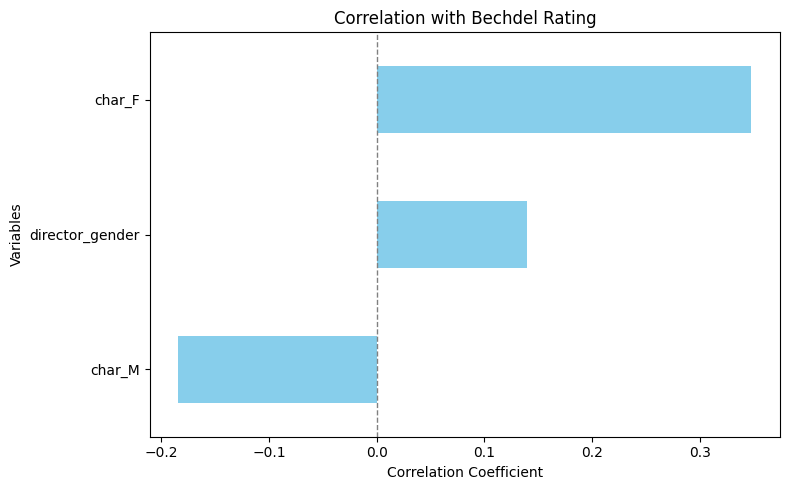

In [16]:
# Correlation values
bechdel_corr = correlations['bechdel_rating'].drop('bechdel_rating')

# Plotting
plt.figure(figsize=(8, 5))
bechdel_corr.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Correlation with Bechdel Rating')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # Mark zero correlation
plt.tight_layout()
plt.show()

### Graphs 

#### Distribution bechdel ratings by director gender 

In [29]:
bechdel_complete = bechdel_complete[["wikipedia_movie_id", "movie_name", "movie_release_date", "bechdel_rating", "director_gender", "char_M", "char_F", "neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]]

In [30]:
# Function to plot the Bechdel Test Ratings by director gender 
def bechdel_test_ratings_by_gender():
    # Calculate histograms for male and female directors
    male_director_hist = (
        bechdel_complete[bechdel_complete['director_gender'] == 0]['bechdel_rating']
        .value_counts(normalize=True) * 100
    )
    female_director_hist = (
        bechdel_complete[bechdel_complete['director_gender'] == 1]['bechdel_rating']
        .value_counts(normalize=True) * 100
    )

    # Get all Bechdel ratings as the x-axis
    x = bechdel_complete['bechdel_rating'].unique()
    # Create bar traces for Male and Female Directors
    trace_male = go.Bar(
        x=x,
        y=male_director_hist.values,
        name='Male Directors',
        width=0.4
    )
    trace_female = go.Bar(
        x=x,
        y=female_director_hist.values,
        name='Female Directors',
        width=0.4
    )
    # Create layout
    layout = go.Layout(
        title="Bechdel Test Ratings by Gender of Directors",
        xaxis=dict(title="Bechdel Rating", tickvals=x),
        yaxis=dict(title="Percentage (%)"),
        barmode='group',  # Group the bars
        bargap=0.2  # Gap between bars
    )
    # Create figure and show plot
    fig = go.Figure(data=[trace_male, trace_female], layout=layout)
    fig.show()


In [31]:
bechdel_test_ratings_by_gender()

#### Radar Graph for different emotions by bechdel test passed or fail

In [32]:
# Calculation of the average emotions for each DataFrame
def compute_mean_emotions(df):
    emotions = ["neutral", "sadness", "anger", "fear", "disgust", "surprise", "joy"]
    return df[emotions].mean()

In [33]:
def graph_emotions_bechdel_combined():
    # creation of datasets that pass or fail the bechdel test
    bechdel_complete_grade3 = bechdel_complete[bechdel_complete["bechdel_rating"]==3]
    bechdel_complete_grade012 = bechdel_complete[bechdel_complete["bechdel_rating"]!=3]

    # Creation of datasets by director gender
    bechdel_complete_grade3_men = bechdel_complete_grade3[bechdel_complete_grade3["director_gender"]==0]
    bechdel_complete_grade3_women = bechdel_complete_grade3[bechdel_complete_grade3["director_gender"]==1]
    bechdel_complete_grade012_men = bechdel_complete_grade012[bechdel_complete_grade012["director_gender"]==0]
    bechdel_complete_grade012_women = bechdel_complete_grade012[bechdel_complete_grade012["director_gender"]==1]

    # Data for the graph
    data_women_grade3 = compute_mean_emotions(bechdel_complete_grade3_women)
    data_men_grade3 = compute_mean_emotions(bechdel_complete_grade3_men)

    data_women_grade012 = compute_mean_emotions(bechdel_complete_grade012_women)
    data_men_grade012 = compute_mean_emotions(bechdel_complete_grade012_men)

    # Creation of a graph with two subplots side by side
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'polar'}, {'type': 'polar'}]],      
    )

    # First graph: For films that pass the Bechdel test (Grade 3)
    fig.add_trace(go.Scatterpolar(
        r=data_men_grade3,
        theta=data_men_grade3.index,
        fill='toself',
        name='Men - Bechdel passed',
        marker_color='gold'
    ), row=1, col=1)

    fig.add_trace(go.Scatterpolar(
        r=data_women_grade3,
        theta=data_women_grade3.index,
        fill='toself',
        name='Women - Bechdel passed',
        marker_color='royalblue'
    ), row=1, col=1)

    # Second graph: For films that do not pass the Bechdel test (Grades 0, 1, 2)
    fig.add_trace(go.Scatterpolar(
        r=data_men_grade012,
        theta=data_men_grade012.index,
        fill='toself',
        name='Men - Bechdel failed',
        marker_color='orange'
    ), row=1, col=2)

    fig.add_trace(go.Scatterpolar(
        r=data_women_grade012,
        theta=data_women_grade012.index,
        fill='toself',
        name='Women - Bechdel failed',
        marker_color='blue'
    ), row=1, col=2)

    fig.update_layout(
        title_text="Emotion Distribution by Gender for Bechdel Test Results",
        showlegend=True,
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 0.25])
        ),
        template="plotly_white"
    )

    fig.show()

In [34]:
graph_emotions_bechdel_combined()
